## SVM
Classifies in the 3-dimensional space of flash parameters (flash duration, number of flashes, interflash gap) using SVM.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools, math
from sklearn.metrics import roc_curve
from svm_params import *

Load labels, flash parameter data, and literature references.

In [2]:
# load data
df_path = '../data/real_data/flash_sequence_data.csv'
df = pd.read_csv(df_path, delimiter=',')
# keep only samples with number of flashes > 1
df = df.loc[df['num_flashes'] > 1].reset_index(drop=True) 
# unpack timeseries
df = pd.concat([df.iloc[:,:-1],pd.DataFrame(np.array(list(itertools.zip_longest(*[list(map(float,x.split(","))) for x in list(df.timeseries.values.flatten())],fillvalue=math.nan))).T
)],axis=1)

# load literature sequences (excludes Bw)
literature_sequences = []
literature_labels = []
header = 0
for l in open('../data/literature_sequences_6.csv'):
    if header > 0:
        header -= 1
        continue
    literature_sequences.append([int(float(x)) for x in l.rstrip().split(',')[1:]])
    literature_labels.append(l.rstrip().split(',')[0])

# load literature reference parameters
params_lit = pd.read_csv('../data/params_lit_6.csv', header=None, names=['num_flashes','flash_length','ifi'])
params_lit['species'] = literature_labels


## Classify using SVM with literature references.

In [3]:
acc, prec, rec, prec_weighted, rec_weighted, conf_mat, y_true, y_pred, y_score, metrics = svmLit(df, params_lit, 1)
print('Weighted precision =', prec_weighted)
print('Weighted Recall =', rec_weighted)

Weighted precision = 0.6717828863658062
Weighted Recall = 0.10021987993857322


In [4]:
# per-species precision and recall
spec_labels=['B. wickershamorum', 'P. bethaniensis', 'P. carolinus', 'P. forresti', 'P. frontalis', 'P. knulli', 'P. obscurellus']
for i in [df[df['species']==label].iloc[0].species_label for label in literature_labels]:
    print('{0} precision = {1:2.5f}, recall = {2:2.5f}'.format(spec_labels[i], metrics[str(i)]['precision'], metrics[str(i)]['recall']))

P. bethaniensis precision = 0.01658, recall = 0.81583
P. carolinus precision = 0.82915, recall = 0.08185
P. forresti precision = 0.01166, recall = 0.43144
P. frontalis precision = 0.26884, recall = 0.03601
P. knulli precision = 0.43911, recall = 0.32527
P. obscurellus precision = 0.44737, recall = 0.01878


 Plot ROC curve.

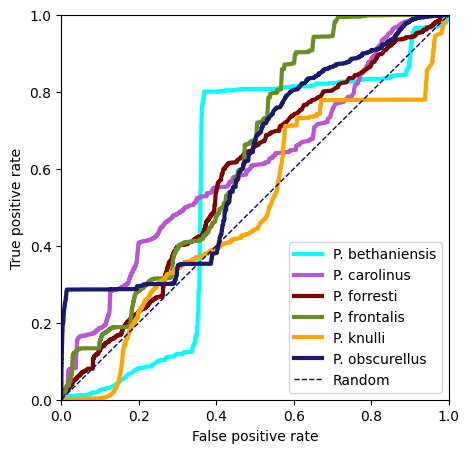

In [5]:
spec_labels=['B. wickershamorum', 'P. bethaniensis', 'P. carolinus', 'P. forresti', 'P. frontalis', 'P. knulli', 'P. obscurellus']
fig,ax=plt.subplots(1,1, figsize=(5, 5))
colormap = {0: 'dodgerblue', 1: 'cyan', 2: 'mediumorchid', 3: 'maroon',
                 4: 'olivedrab', 5: 'orange', 6: 'midnightblue'}

for i, sp in enumerate([df[df['species']==label].iloc[0].species_label for label in literature_labels]):
    fpr, tpr, thresholds = roc_curve(y_true, y_score[:,i].flatten(), pos_label=sp)
    lw = 3
    ax.plot(
        fpr,
        tpr,
        color=colormap[sp],
        lw=lw,
        label=spec_labels[sp],
    )
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
ax.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--", label="Random")
plt.legend()
plt.show()


Plot confusion matrix.

[Text(0, 0.5, 'P. bethaniensis'),
 Text(0, 1.5, 'P. carolinus'),
 Text(0, 2.5, 'P. forresti'),
 Text(0, 3.5, 'P. frontalis'),
 Text(0, 4.5, 'P. knulli'),
 Text(0, 5.5, 'P. obscurellus')]

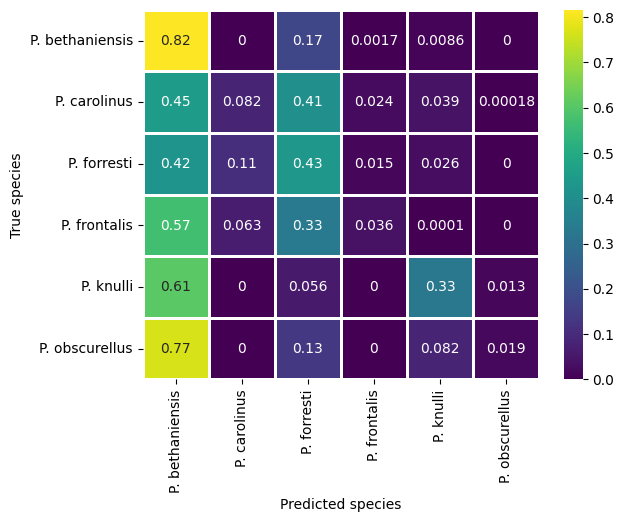

In [6]:
fig,ax = plt.subplots()
sns.heatmap(conf_mat, linewidths=1, cmap='viridis', ax=ax, annot=True, fmt='.2g')
ax.set_ylabel('True species')
ax.set_xlabel('Predicted species')
ax.set_xticklabels(spec_labels[1:], rotation=90)
ax.set_yticklabels(spec_labels[1:], rotation=0)

In [7]:
# Optional: pickle the output
import pickle
data = {
    "acc": acc,
    "prec": prec,
    "rec": rec,
    "prec_weighted": prec_weighted,
    "rec_weighted": rec_weighted,
    "conf_mat": conf_mat,
    "y_true": y_true,
    "y_pred": y_pred,
    "y_score": y_score,
    "metrics": metrics
}
with open("svm_lit", "wb") as f:
        pickle.dump(data, f)

## Classify using 3-parameter SVM with population references.

In [8]:
# run for 150 folds
k = 150
train_split = 0.8
accs, precs, recs, precs_weighted, recs_weighted, conf_mat, y_true, y_pred, y_score, precs_sp, recs_sp = svmPop(df, k, train_split, 1)

In [9]:
spec_labels=['B. wickershamorum', 'P. bethaniensis', 'P. carolinus', 'P. forresti', 'P. frontalis', 'P. knulli', 'P. obscurellus']
print('Overall weighted precision = {0:2.5f}'.format(np.mean(precs_weighted)), ' +/- {0:2.5f}'.format(np.std(precs_weighted)))
print('Overall weighted recall = {0:2.5f}'.format(np.mean(recs_weighted)), ' +/- {0:2.5f}'.format(np.std(recs_weighted)))
for i in range(len(spec_labels)):
    print('{0} precision = {1:2.5f}, recall = {2:2.5f}'.format(spec_labels[i], np.mean(precs_sp[i]), np.mean(recs_sp[i])))

Overall weighted precision = 0.75431  +/- 0.00458
Overall weighted recall = 0.37658  +/- 0.01514
B. wickershamorum precision = 0.46466, recall = 0.79499
P. bethaniensis precision = 0.02851, recall = 0.79106
P. carolinus precision = 0.96995, recall = 0.18324
P. forresti precision = 0.00383, recall = 0.30699
P. frontalis precision = 0.46387, recall = 0.82665
P. knulli precision = 0.19654, recall = 0.24341
P. obscurellus precision = 0.20852, recall = 0.68618


Plot ROC curve.

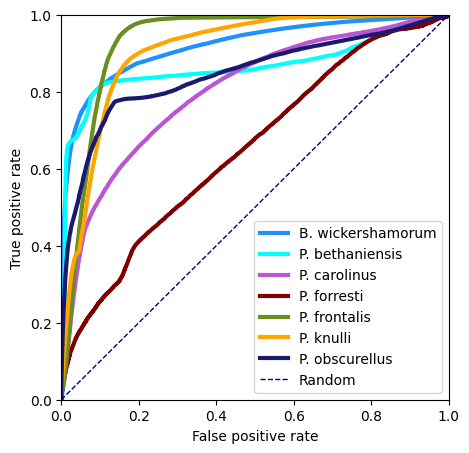

In [10]:
spec_labels=['B. wickershamorum', 'P. bethaniensis', 'P. carolinus', 'P. forresti', 'P. frontalis', 'P. knulli', 'P. obscurellus']
fig,ax=plt.subplots(1,1, figsize=(5, 5))
colormap = {0: 'dodgerblue', 1: 'cyan', 2: 'mediumorchid', 3: 'maroon',
                 4: 'olivedrab', 5: 'orange', 6: 'midnightblue'}

for sp in range(len(np.unique(df['species_label']))):
    fpr, tpr, thresholds = roc_curve(y_true, y_score[:,sp].flatten(), pos_label=sp)
    lw = 3
    ax.plot(
        fpr,
        tpr,
        color=colormap[sp],
        lw=lw,
        label=spec_labels[sp],
    )
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel("False positive rate")
    ax.set_ylabel("True positive rate")
ax.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--", label="Random")
plt.legend()
plt.show()

Plot confusion matrix.

[Text(0, 0.5, '1'),
 Text(0, 1.5, '2'),
 Text(0, 2.5, '3'),
 Text(0, 3.5, '4'),
 Text(0, 4.5, '5'),
 Text(0, 5.5, '6'),
 Text(0, 6.5, '7')]

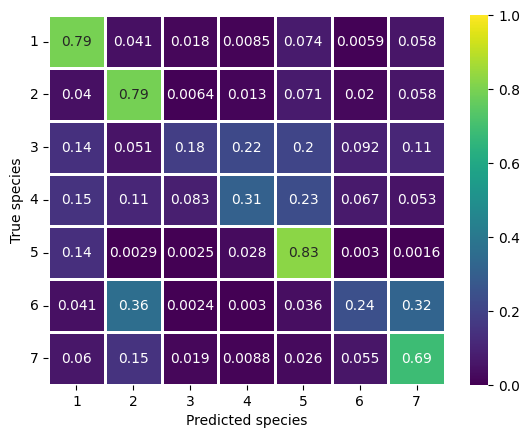

In [11]:
fig,ax = plt.subplots()
sns.heatmap(conf_mat, linewidths=1, cmap='viridis', ax=ax, annot=True, fmt='.2g',vmin=0,vmax=1)
ax.set_ylabel('True species')
ax.set_xlabel('Predicted species')
spec_labels=['1','2','3','4','5','6','7']

ax.set_xticklabels(spec_labels, rotation=0)
ax.set_yticklabels(spec_labels, rotation=0)

In [12]:
# Optional: pickle the output
import pickle
data = {
    "accs": accs,
    "precs": precs,
    "recs": recs,
    "precs_weighted": precs_weighted,
    "recs_weighted": recs_weighted,
    "conf_mat": conf_mat,
    "y_true": y_true,
    "y_pred": y_pred,
    "y_score": y_score,
    "precs_sp": precs_sp,
    "recs_sp": recs_sp
}
with open("svm_pop", "wb") as f:
        pickle.dump(data, f)

/opt/homebrew/Caskroom/miniforge/base/envs/firefly/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


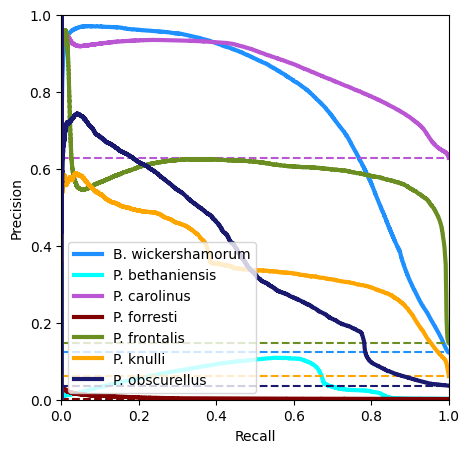

In [13]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

spec_labels=['B. wickershamorum', 'P. bethaniensis', 'P. carolinus', 'P. forresti', 'P. frontalis', 'P. knulli', 'P. obscurellus']
fig,ax=plt.subplots(1,1, figsize=(5, 5))
colormap = {0: 'dodgerblue', 1: 'cyan', 2: 'mediumorchid', 3: 'maroon',
                 4: 'olivedrab', 5: 'orange', 6: 'midnightblue'}

classes = range(len(np.unique(df['species_label']))) # species
for sp in classes:
    precision, recall, _ = precision_recall_curve(label_binarize(y_true, classes=classes)[:,sp], y_score[:,sp].flatten())
    lw = 3
    ax.plot(
        recall,
        precision,
        color=colormap[sp],
        lw=lw,
        label=spec_labels[sp]
    )
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    no_skill = len(np.where(np.array(y_true)==sp)[0])/len(y_true)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color=colormap[sp])
plt.legend()
plt.show()
